<tf.Tensor: id=238453, shape=(), dtype=float32, numpy=0.013262915>

In [115]:
scale

<tf.Tensor: id=1153989, shape=(2, 2), dtype=float32, numpy=
array([[0.6, 0. ],
       [0.2, 0.5]], dtype=float32)>

In [116]:
tfd.MultivariateNormalTriL(mu,scale_tril=scale).prob([1,3])

<tf.Tensor: id=1154764, shape=(), dtype=float32, numpy=0.5305165>

In [186]:
from scipy.special import erf
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

def pdist(x):
    return 2*tfd.MultivariateNormalFullCovariance([1.0,2.0],[[2.0,.5],[.5,1.0]]).prob(x)+tfd.MultivariateNormalFullCovariance([3.0,4.0],[[1.0,0],[0,0.5]]).prob(x)
    #return tfd.MultivariateNormalFullCovariance([1.0,2.0],[[2.0,.5],[.5,1.0]]).prob(x)
def logpdist(x):
    logp = tf.math.log(1e-30+pdist(x))
    assert np.all(np.isfinite(logp))
    return logp

discrepancy_fn = tfp.vi.kl_forward 
#discrepancy_fn = tfp.vi.kl_reverse
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
mu = tf.Variable([0.0,0.0],dtype=tf.float32)
#scale = tf.Variable([3.0,4.0],dtype=tf.float32)
#mu = tf.Variable([1., 3],dtype=tf.float32)
#cov = [[ 0.36,  0.12], [ 0.12,  0.29]]
#scale = tf.linalg.cholesky(cov,)
scale = tf.Variable([[20.0,0],[0,20.0]],dtype=tf.float32)

for it in range(1000):
    with tf.GradientTape() as tape:
        #surrogate_posterior = tfd.MultivariateNormalDiag(mu,scale_diag=scale)
        surrogate_posterior = tfd.MultivariateNormalTriL(mu,scale_tril=scale)
        elbo_loss = tfp.vi.monte_carlo_variational_loss(logpdist,surrogate_posterior,sample_size=1000,discrepancy_fn=discrepancy_fn) #,use_reparametrization=True)
    gradients = tape.gradient(elbo_loss, [mu,scale])
    optimizer.apply_gradients(zip(gradients, [mu,scale]))
    if it%50==0: print("%0.3f, %0.3f, %0.3f" % (scale.numpy()[0,0],mu.numpy()[0],elbo_loss.numpy()))


19.900, -0.100, 12.889
17.805, 0.003, 10.388
16.692, 0.196, 25.047
14.522, -0.559, 16.734
13.100, 0.004, 14.896
10.597, -0.391, 15.116
7.649, -0.554, 12.548
5.938, 0.418, 10.975
1.869, 0.611, 8.866
1.608, 1.525, 7.636
1.665, 1.716, 6.322
1.713, 1.370, 3.421
1.519, 1.642, 3.412
1.618, 1.658, 3.412
1.571, 1.666, 3.389
1.551, 1.588, 3.327
1.566, 1.662, 3.516
1.624, 1.666, 3.408
1.600, 1.664, 3.313
1.624, 1.700, 3.467


KeyboardInterrupt: 

In [187]:
cov = scale.numpy() @ scale.numpy().T

(-2, 5)

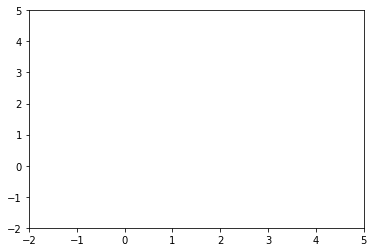

In [196]:
def drawellipse(mu,cov,col='k'):
    """
    mu = mean vector
    cov = covariance matrix
    col = colour
    """
    #based on https://stackoverflow.com/questions/20126061/creating-a-confidence-ellipses-in-a-sccatterplot-using-matplotlib
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    from matplotlib.patches import Ellipse
    import matplotlib.pyplot as plt
    ax = plt.subplot(111, aspect='equal')

    for j in [2]:
        ell = Ellipse(xy=mu,
                      width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                      angle=np.rad2deg(np.arccos(v[0, 0])),color=col,lw=2)
        ell.set_facecolor('none')
        ax.add_artist(ell)  
plt.figure()
#drawellipse(mu.numpy(),np.diag(scale.numpy()**2),'k')
#drawellipse([1.0,2.0],[[3.0,1.0],[1.0,2.0]],'b')
plt.xlim([-2,5])
plt.ylim([-2,5])

In [197]:

delta = 0.1
x = np.arange(-5.0, 10.0, delta)
y = np.arange(-5.0, 10.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

In [198]:
cov

array([[2.476, 1.28 ],
       [1.28 , 1.672]], dtype=float32)

In [199]:
np.linalg.eig(cov)

(array([3.416, 0.733], dtype=float32), array([[ 0.806, -0.592],
        [ 0.592,  0.806]], dtype=float32))

In [200]:
mu

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1.7  , 2.655], dtype=float32)>

In [201]:
cov

array([[2.476, 1.28 ],
       [1.28 , 1.672]], dtype=float32)

(-2, 7)

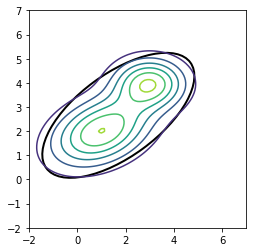

In [202]:
#drawellipse(mu.numpy(),np.diag(scale.numpy()**2),'k')

drawellipse(mu.numpy(),cov,'k')
plt.contour(x,y,pdist(np.vstack([X.flatten(),Y.flatten()]).T).numpy().reshape(X.shape[0],X.shape[1]))
plt.xlim([-2,7])
plt.ylim([-2,7])

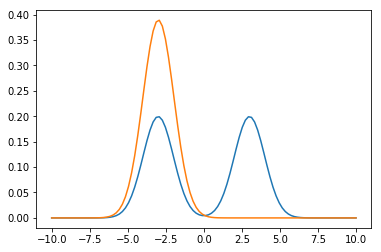

In [5]:
inx = np.linspace(-10,10,100)
a = pdist(inx)
#np.sum(a)*(inx[1]-inx[0])
plt.plot(inx,a)
plt.plot(inx,surrogate_posterior.prob(inx))